<a href="https://colab.research.google.com/github/DanielTaylor97/DNN-TS-bootcamp/blob/main/tryPytorchMLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#!pip install pytorch-lightning

In [ ]:
from __future__ import division
import pytorch_lightning as pl
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda, Compose
import matplotlib.pyplot as plt
import numpy as np

## Create Sine Wave Data

In [ ]:
def generate_time_series(batch_size, n_steps, freq_scale = 10):
  freq, offset = np.random.rand(2, batch_size, 1)
  t = np.linspace(0, 1, n_steps)
  signals = np.sin((t - offset)*(freq*freq_scale + freq_scale))
  signals += 0.1*(np.random.rand(batch_size, n_steps) - 0.5)

  return signals.astype(np.float32)

## Create Training, Validation and Test Sets from Data

In [ ]:
n_steps = 100
n_predictions = 20
hidden_features = 30
total = 10000

series = generate_time_series(total, n_steps + n_predictions)

X_train = torch.Tensor(series[:int(0.7*total), :n_steps])
y_train = torch.Tensor(series[:int(0.7*total), n_steps:])

X_valid = torch.Tensor(series[int(0.7*total):int(0.9*total), :n_steps])
y_valid = torch.Tensor(series[int(0.7*total):int(0.9*total), n_steps:])

X_test = torch.Tensor(series[int(0.9*total):, :n_steps])
y_test = torch.Tensor(series[int(0.9*total):, n_steps:])

training_data = TensorDataset(X_train, y_train)
valid_data = TensorDataset(X_valid, y_valid)
test_data = TensorDataset(X_test, y_test)

## Configuring Data Loader

In [ ]:
batch_size = 64

train_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

for X, y in test_dataloader:
  print('Shape of X [N, C, H, W]: {}'.format(X.shape))
  print('Shape of y: {} {}'.format(y.shape, y.dtype))

Shape of X [N, C, H, W]: torch.Size([64, 100])
Shape of y: torch.Size([64, 20]) torch.float32
Shape of X [N, C, H, W]: torch.Size([64, 100])
Shape of y: torch.Size([64, 20]) torch.float32
Shape of X [N, C, H, W]: torch.Size([64, 100])
Shape of y: torch.Size([64, 20]) torch.float32
Shape of X [N, C, H, W]: torch.Size([64, 100])
Shape of y: torch.Size([64, 20]) torch.float32
Shape of X [N, C, H, W]: torch.Size([64, 100])
Shape of y: torch.Size([64, 20]) torch.float32
Shape of X [N, C, H, W]: torch.Size([64, 100])
Shape of y: torch.Size([64, 20]) torch.float32
Shape of X [N, C, H, W]: torch.Size([64, 100])
Shape of y: torch.Size([64, 20]) torch.float32
Shape of X [N, C, H, W]: torch.Size([64, 100])
Shape of y: torch.Size([64, 20]) torch.float32
Shape of X [N, C, H, W]: torch.Size([64, 100])
Shape of y: torch.Size([64, 20]) torch.float32
Shape of X [N, C, H, W]: torch.Size([64, 100])
Shape of y: torch.Size([64, 20]) torch.float32
Shape of X [N, C, H, W]: torch.Size([64, 100])
Shape of y: t

## Create Model

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device.'.format(device))

class MLP(nn.Module):
  def __init__(self, window_size, hidden_size, output_size):
    super(MLP, self).__init__()
    '''self.linear_stack = nn.Sequential(nn.Linear(window_size, hidden_size),
                                      nn.ReLU(),
                                      nn.Linear(hidden_size, output_size),
                                      )'''
    self.first_linear = nn.Linear(window_size, hidden_size)
    self.relu = nn.ReLU()
    self.second_linear = nn.Linear(hidden_size, output_size)

  def forward(self, x):
    #logits = self.linear_stack(x)
    next = self.first_linear(x)
    next = self.relu(next)
    out = self.second_linear(next)
    return out

model = MLP(n_steps, hidden_features, n_predictions).to(device)
print(model)

Using cpu device.
MLP(
  (first_linear): Linear(in_features=100, out_features=30, bias=True)
  (relu): ReLU()
  (second_linear): Linear(in_features=30, out_features=20, bias=True)
)


## Configuring Model Parameters

In [ ]:
loss_fn = nn.MSELoss()
optimiser = torch.optim.Adam(model.parameters(), lr=1e-5)

## Define Training Function

In [ ]:
def train(dataloader, model, loss_fn, optimiser):
  size = len(dataloader.dataset)
  for batch, (X, y) in enumerate(dataloader):
    X, y = X.to(device), y.to(device)

    pred = model(X)
    loss = loss_fn(pred, y)

    optimiser.zero_grad()
    loss.backward()
    optimiser.step()

    '''if batch % 10 == 0:
      loss, current = loss.item(), batch*len(X)
      print(f'Loss: {loss:>7f} [{current:>5d}/{size:>5d}]')'''

## Define Testing Function

In [ ]:
def test(dataloader, model, loss_fn):
  size = len(dataloader.dataset)
  num_batches = len(dataloader)
  model.eval()
  test_loss, correct = 0, 0

  with torch.no_grad():
    for X, y in dataloader:
      X, y = X.to(device), y.to(device)
      pred = model(X)
      test_loss += loss_fn(pred, y).item()
      #correct += (pred.argmax(1) == y).type(torch.float).sum().item()
  
  test_loss /= num_batches
  #correct /= size

  #print(f'Test error: \n Accuracy: {100*correct:>0.1f}%, Avg Loss: {test_loss:>8f} \n')
  print(f'Test error: Avg MSE: {test_loss:>8f} \n\n')

## Train and Test Model

In [ ]:
epochs = 100

for t in range(epochs):
  print(f'Epoch {t + 1}\n-------------------------------')
  train(train_dataloader, model, loss_fn, optimiser)
  test(test_dataloader, model, loss_fn)
print('Done!')

Epoch 1
-------------------------------
Test error: Avg MSE: 0.015045 


Epoch 2
-------------------------------
Test error: Avg MSE: 0.015026 


Epoch 3
-------------------------------
Test error: Avg MSE: 0.014948 


Epoch 4
-------------------------------
Test error: Avg MSE: 0.014685 


Epoch 5
-------------------------------
Test error: Avg MSE: 0.014784 


Epoch 6
-------------------------------
Test error: Avg MSE: 0.014645 


Epoch 7
-------------------------------
Test error: Avg MSE: 0.014501 


Epoch 8
-------------------------------
Test error: Avg MSE: 0.014406 


Epoch 9
-------------------------------
Test error: Avg MSE: 0.014349 


Epoch 10
-------------------------------
Test error: Avg MSE: 0.014309 


Epoch 11
-------------------------------
Test error: Avg MSE: 0.014528 


Epoch 12
-------------------------------
Test error: Avg MSE: 0.014134 


Epoch 13
-------------------------------
Test error: Avg MSE: 0.014245 


Epoch 14
-------------------------------
Test e

## Visualise Predictions

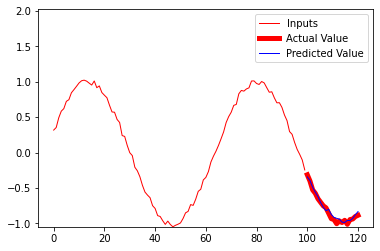

In [ ]:
pos = np.random.randint(0, X_valid.shape[0])

single_X = X_valid[pos: pos + 1]
single_y = y_valid[pos: pos + 1]

single_pred = model(single_X)

input_space = np.linspace(0, n_steps - 1, num=n_steps)
prediction_space = np.linspace(n_steps, n_steps + n_predictions, num=n_predictions)

plt.plot(input_space, single_X.numpy()[0], linewidth=1.0, color='r', label='Inputs')
if n_predictions==1:
  print('Difference:\n\tActual: {}\n\tPredicted: {}'.format(single_y.numpy(), single_pred.detach().numpy()))
  
  plt.plot(prediction_space, single_y.numpy()[0], linewidth=0, marker='.', color='r', markersize=10, label='Actual Value')
  plt.plot(prediction_space, single_pred.detach().numpy()[0], linewidth=0, marker='.', color='b', markersize=10, label='Predicted_value')
else:
  plt.plot(prediction_space, single_y.numpy()[0], linewidth=5.0, color='r', label='Actual Value')
  plt.plot(prediction_space, single_pred.detach().numpy()[0], linewidth=1.0, color='b', label='Predicted Value')
plt.legend()
plt.ylim(np.min(single_X.numpy()[0]), np.max(single_X.numpy()[0]) + 1)
plt.show()

## Save Model

In [ ]:
torch.save(model.state_dict(), 'model.pth')
print('Saved PyTorch model state to model.pth')

## Load Model

In [ ]:
model = NeuralNetwork()
model.load_state_dict(torch.load('model.pth'))